# Noise experiments

In [1]:
import numpy as np
import mnist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gaussian import gaussian
from cnn_parallell import make_t_sne, experiment1, experiment2, experiment3, experiment4, experiment6
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from cnn_score import score_clfs_noisy, split_train_two


In [2]:
plt.rcParams["figure.figsize"] = (4,3)


In [3]:
DATA_SIZE = 20000
TEST_FRACTION = 0.5

imgs = mnist.train_images()/255.0
labels = mnist.train_labels()
data_train = imgs[0:DATA_SIZE, 1:, 1:]
labels_train = labels[0:DATA_SIZE]
mnist_copy = data_train.copy()
subset_flattened = data_train.reshape(DATA_SIZE, 27*27)

noises = [.1, .2, .3, .4, .5]

noisy_mnists = [np.array([img + np.random.normal(.0, noise, size=(data_train[0].shape)) for img in mnist_copy]) for noise in noises]
noisy_mnists_flattened = [data.reshape(DATA_SIZE, 27*27) for data in noisy_mnists]

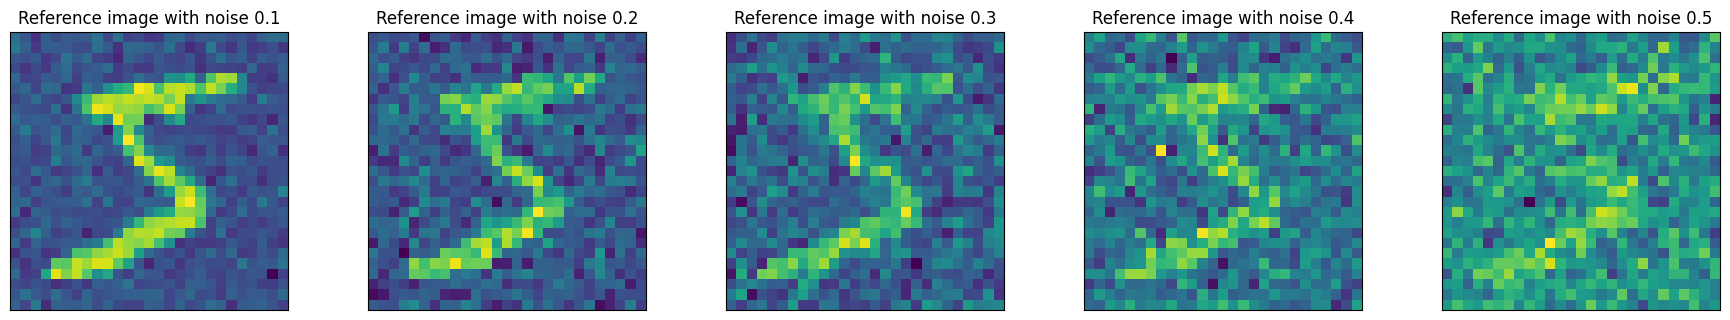

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(noisy_mnists[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with noise {noises[i]}")
plt.tight_layout(pad=0.0)


## Comparing performance on noisy mnist

In [5]:
lr_best_tols = {
    "baseline": 0.01,
    "exp1": 0.001,
    "exp2": 0.001,
    "exp3": 0.0005,
    "exp4": 0.0005,
    "exp5": 0.001,
    "exp6": 0.005
}

scores_noisy_lr = []

In [20]:
transformed_flat_dataset = [split_train_two(func=None,
                                            X1=subset_flattened, 
                                            X2=noisy_mnist_data, 
                                            y=labels_train,
                                            test_size=TEST_FRACTION,
                                            random_state=0) for noisy_mnist_data in noisy_mnists_flattened]

### Logistic regression

#### Baseline - LR

In [21]:
clfs_bl = [LogisticRegression(fit_intercept=True,
                              multi_class='multinomial',
                              penalty='l2',
                              solver='saga',
                              max_iter=1000,
                              n_jobs=8,
                              tol=lr_best_tols["baseline"]) for _ in range(len(noises))]
baseline_lr_scores = score_clfs_noisy(clfs_bl, transformed_flat_dataset)
scores_noisy_lr.append(baseline_lr_scores)

Text(3.972222222222223, 0.5, 'Accuracy score')

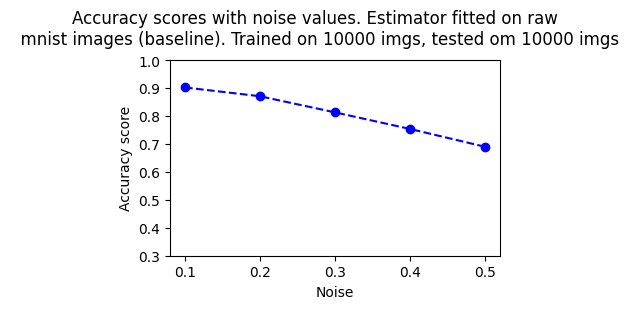

In [10]:
plt.plot([str(t) for t in noises], baseline_lr_scores, linestyle='--', marker='o', color='b', label='Accuracy score')
plt.tight_layout(rect=(0., 0.03, 1., 0.86))
plt.suptitle(f"Accuracy scores with noise values. Estimator fitted on raw\n  mnist images (baseline). Trained on 10000 imgs, tested om 10000 imgs")
plt.ylim([.3, 1.])
plt.xlabel("Noise") 
plt.ylabel("Accuracy score") 

#### Experiment 1 - LR

In [23]:
dataset_exp1 = [split_train_two(experiment1,
                                noisy_mnist_data,
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0) for noisy_mnist_data in noisy_mnists]

In [24]:
clfs_lr_ex1 = [LogisticRegression(fit_intercept=True,
                           multi_class='multinomial',
                           penalty='l2',
                           solver='saga',
                           max_iter=1000,
                           n_jobs=8,
                           tol=lr_best_tols["exp1"]) for _ in range(len(noises))]

lr_noisy_scord = score_clfs_noisy(clfs_lr_ex1, dataset_exp1)                        
#scores_noisy_lr.append(lr_noisy_scord)

#### Experiment 2 - LR

In [25]:
dataset_exp2 = [split_train_two(experiment2,
                                noisy_mnist_data, 
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0) for noisy_mnist_data in noisy_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [26]:
clfs_lr_ex2 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=8,
                                  tol=lr_best_tols["exp2"]) for _ in range(len(noises))]

lr_noisy_exp2_score = score_clfs_noisy(clfs_lr_ex2, dataset_exp2)                        
#scores_noisy_lr.append(lr_noisy_exp2_score)

#### Experiment 3 - LR

In [9]:
dataset_exp3 = [split_train_two(experiment3,
                                noisy_mnist_data, 
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0) for noisy_mnist_data in noisy_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [16]:
print(scores_noisy_lr)

[[0.9031, 0.8717, 0.814, 0.7547, 0.6909], [0.8835, 0.8762, 0.8556, 0.8269, 0.7704], [0.6975, 0.7006, 0.689, 0.6561, 0.5663]]


In [8]:
scores_noisy_lr.append([0.6975, 0.7006, 0.689, 0.6561, 0.5663])

In [10]:
clfs_lr_ex3 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=8,
                                  tol=lr_best_tols["exp3"]) for _ in range(len(noises))]

scores_noisy_lr.append(score_clfs_noisy(clfs_lr_ex3, dataset_exp3))

### Experiment 4 - LR

In [11]:
dataset_exp4 = [split_train_two(experiment4,
                                noisy_mnist_data,  
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0) for noisy_mnist_data in noisy_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [12]:
clfs_lr_ex4 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=8,
                                  tol=lr_best_tols["exp4"]) for _ in range(len(noises))]

scores_noisy_lr.append(score_clfs_noisy(clfs_lr_ex4, dataset_exp4))

### Experiment 5 - LR

In [13]:
dataset_exp5 = [split_train_two(experiment4,
                                noisy_mnist_data, 
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0,
                                length=4) for noisy_mnist_data in noisy_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [14]:
clfs_lr_ex5 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=8,
                                  tol=lr_best_tols["exp5"]) for _ in range(len(noises))]

scores_noisy_lr.append(score_clfs_noisy(clfs_lr_ex5, dataset_exp5))

### Experiment 6 - LR

In [15]:
dataset_exp6 = [split_train_two(experiment6,
                                noisy_mnist_data, 
                                data_train,
                                labels_train,
                                test_size=TEST_FRACTION,
                                random_state=0,
                                threshhold=0.85) for noisy_mnist_data in noisy_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [16]:
clfs_lr_ex6 = [LogisticRegression(fit_intercept=True,
                                  multi_class='multinomial',
                                  penalty='l2',
                                  solver='saga',
                                  max_iter=1000,
                                  n_jobs=8,
                                  tol=lr_best_tols["exp6"]) for _ in range(len(noises))]

scores_noisy_lr.append(score_clfs_noisy(clfs_lr_ex6, dataset_exp6))

### Results from LR

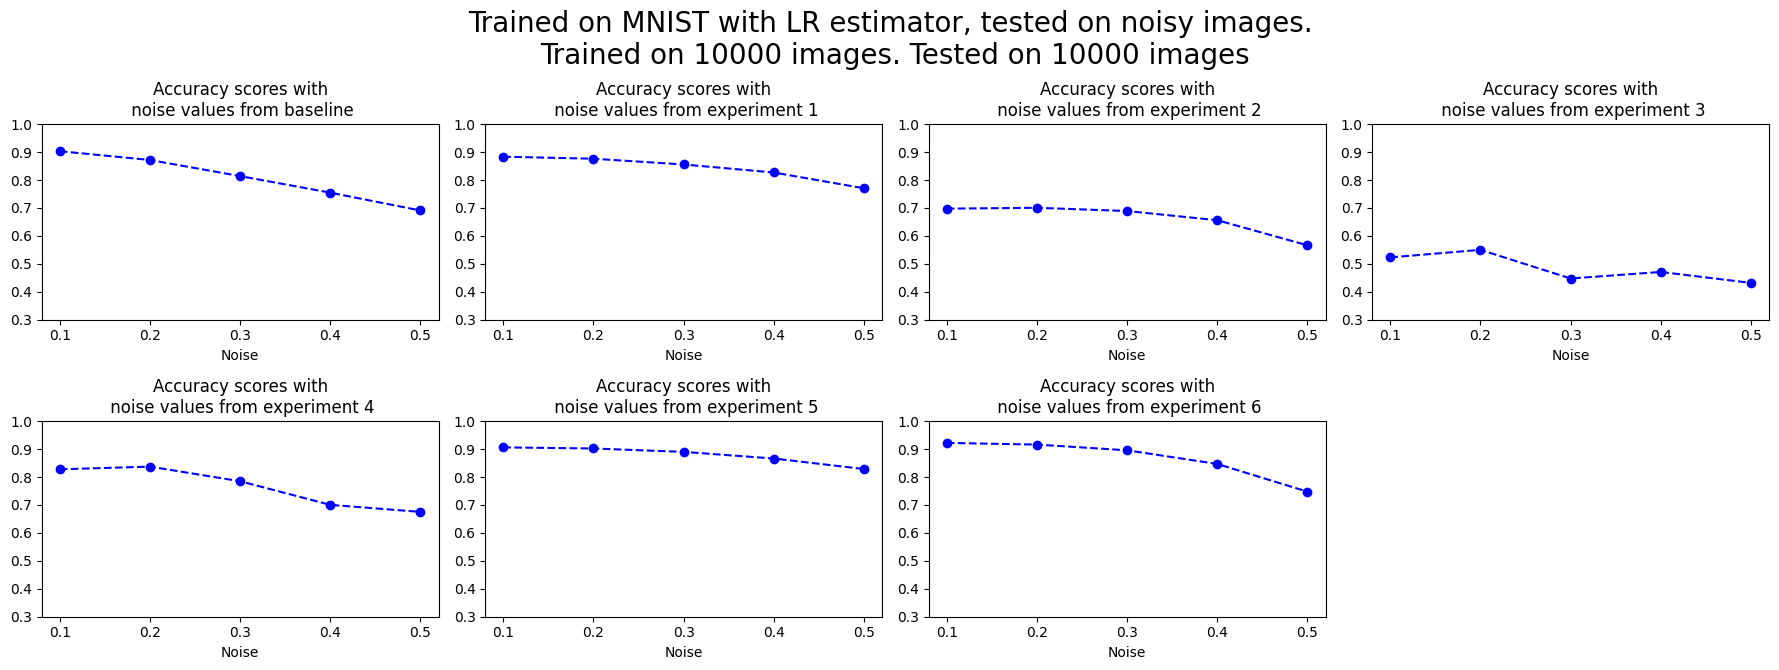

In [73]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7))
for i in range(7):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_noisy_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from experiment {i}" if i > 0 else "Accuracy scores with\n noise values from baseline")
    ax[k][j].set_ylim([.3, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on noisy images. \nTrained on {int((1 - TEST_FRACTION) * DATA_SIZE)} images. Tested on {int(TEST_FRACTION * DATA_SIZE)} images",
             fontsize=20)
fig.delaxes(ax[1,3])

### SVM

In [18]:
svm_best_Cs = {
    "baseline": 10.,
    "exp1": 500.,
    "exp2": 500.,
    "exp3": 500.,
    "exp4": 500.,
    "exp5": 500.,
    "exp6": 10.
}

scores_noisy_svm = []

#### Baseline - SVM

In [28]:
clfs_svm_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_bl, transformed_flat_dataset))

#### Experiment 1 - SVM

In [29]:
clfs_svm_exp1 = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp1, dataset_exp1))

#### Experiment 2 - SVM

In [30]:
clfs_svm_exp2 = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp2, dataset_exp2))

#### Experiment 3 - SVM

In [31]:
clfs_svm_exp3 = [SVC(kernel='rbf', C=svm_best_Cs["exp3"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp3, dataset_exp3))

#### Experiment 4 - SVM

In [32]:
clfs_svm_exp4 = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp4, dataset_exp4))

#### Experiment 5 - SVM

In [33]:
clfs_svm_exp5 = [SVC(kernel='rbf', C=svm_best_Cs["exp5"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp5, dataset_exp5))

#### Experiment 6 - SVM

In [34]:
clfs_svm_exp6 = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(noises))]
scores_noisy_svm.append(score_clfs_noisy(clfs_svm_exp6, dataset_exp6))

### Results from SVM

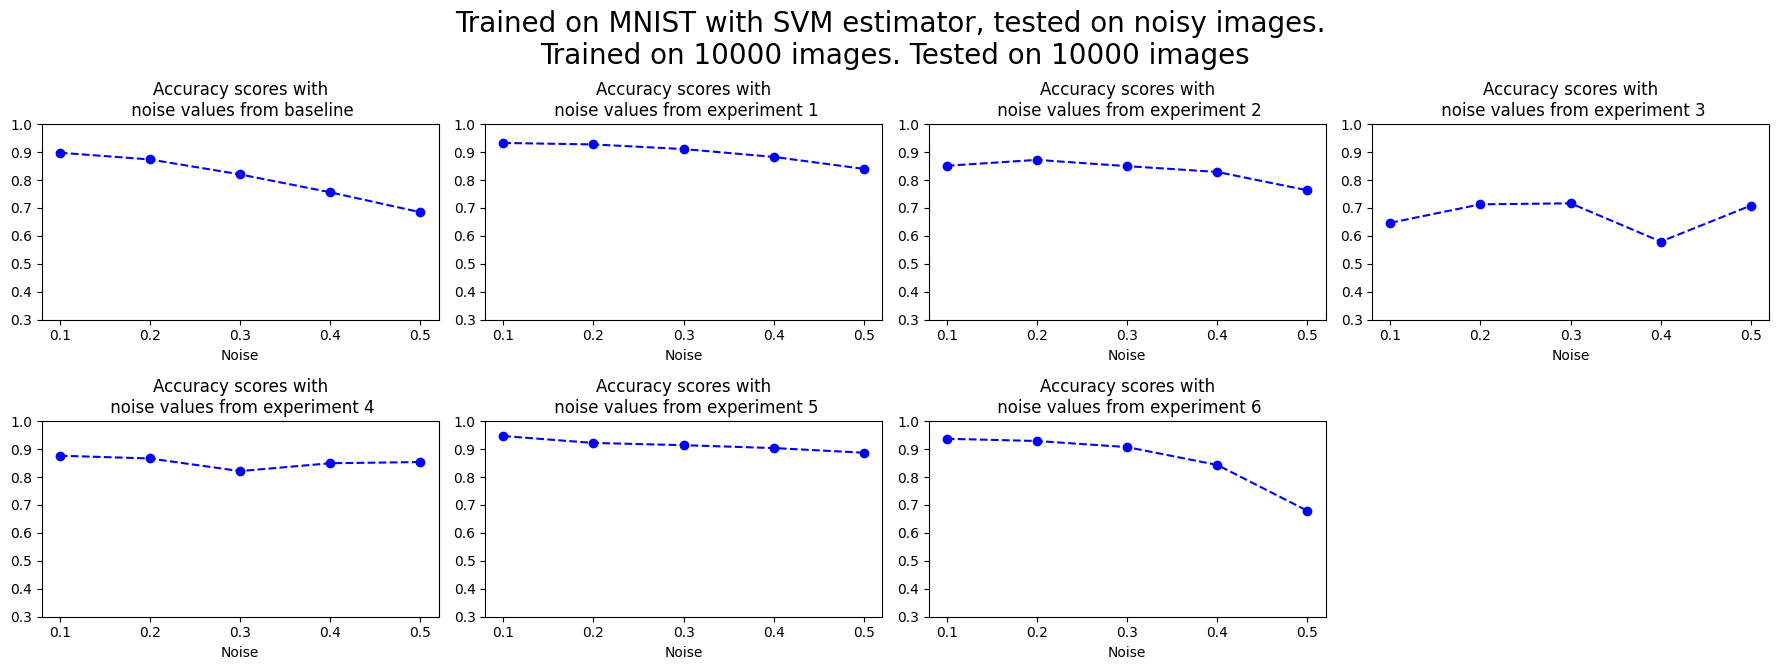

In [74]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7))
for i in range(7):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in noises], scores_noisy_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n noise values from experiment {i}" if i > 0 else "Accuracy scores with\n noise values from baseline")
    ax[k][j].set_ylim([.3, 1.])
    ax[k][j].set_xlabel("Noise") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested on noisy images. \nTrained on {int((1 - TEST_FRACTION) * DATA_SIZE)} images. Tested on {int(TEST_FRACTION * DATA_SIZE)} images",
             fontsize=20)
fig.delaxes(ax[1,3])

### Testing with CNN - Baseline

In [62]:
cnn_scores_noise = []

In [63]:
from tensorflow import keras
from tensorflow.keras import layers

2024-04-16 11:23:52.898276: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 11:23:52.901283: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 11:23:52.944897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11:23:53.726027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [75]:
data_train_cnn = [data_train for _ in range(len(noises))]
noisy_mnists_pixelshape = [np.expand_dims(data, -1) for data in data_train_cnn]
input_shape = noisy_mnists_pixelshape[0][0].shape[-3:]
classes = np.unique(labels_train).shape[0]
labels_binary = keras.utils.to_categorical(labels_train, classes)

In [76]:
transformed_baseline_dataset = [train_test_split(data_, 
                                                 labels_binary,
                                                 test_size=TEST_FRACTION,
                                                 random_state=0) for data_ in noisy_mnists_pixelshape]

In [94]:
def make_model_baseline(input_shape, num_classes):
    return keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

def add_noise(std, img, shape):
    noi = np.random.normal(.0, std, size=shape)
    return img + noi[..., np.newaxis]


def score_cnn(clfs, dataset):
    scores = []
    batch_size = 128
    epochs = 15

    for i, clf in enumerate(clfs):
        X_te = dataset[i][1]
        X_te = np.array([add_noise(noises[i], img, (27, 27)) for img in X_te])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(dataset[i][0], dataset[i][2], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, dataset[i][3], verbose=0)[1])
    return scores

In [101]:
clfs_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(noises))]
cnn_scores_noise.append(score_cnn(clfs_bl_cnn, transformed_baseline_dataset))

Text(0.5, 1.0, 'CNN accuracy scores with noise values from baseline')

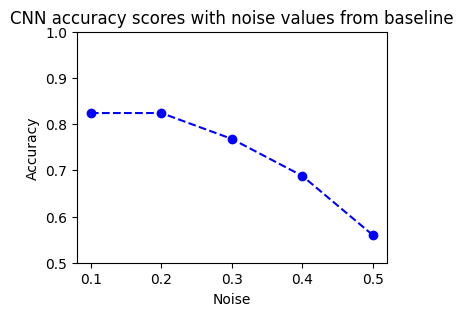

In [103]:
plt.plot([str(t) for t in noises], cnn_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.5, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with noise values from baseline")


## Another type of noise: image blackouts

In [36]:
def black_out_section(image, size):
    offset = 28 - size
    start_row = np.random.randint(3, offset-3)
    start_col = np.random.randint(3, offset-3)
    image_copy = image.copy()
    image_copy[start_row:start_row+size, start_col:start_col+size] = 0
    return image_copy

blackout_sizes = np.arange(3, 18, 3)
blackout_mnists = [np.array([black_out_section(img, size) for img in mnist_copy]) for size in blackout_sizes]

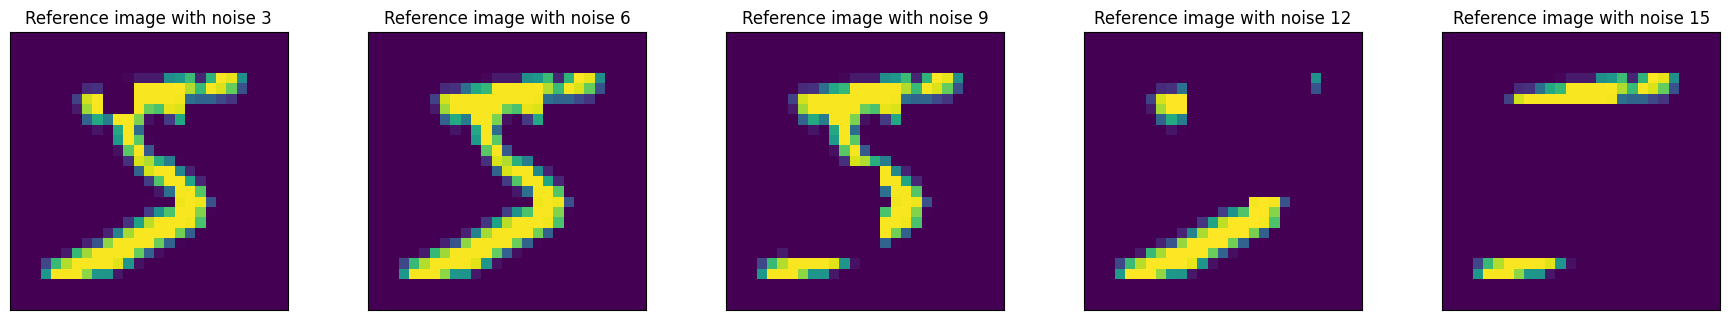

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5): 
    ax[i].imshow(blackout_mnists[i][0])
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(f"Reference image with noise {blackout_sizes[i]}")
plt.tight_layout(pad=0.0)

### LR

In [38]:
scores_blackout_lr = []

### Baseline

In [39]:
blackout_mnists_flattened = [data.reshape(DATA_SIZE, 27*27) for data in blackout_mnists]
transformed_flat_dataset_blackout = [split_train_two(func=None,
                                                     X1=subset_flattened, 
                                                     X2=data, 
                                                     y=labels_train,
                                                     test_size=TEST_FRACTION,
                                                     random_state=0) for data in blackout_mnists_flattened]

In [40]:

clfs_bl_lr = [LogisticRegression(fit_intercept=True,
                                 multi_class='multinomial',
                                 penalty='l2',
                                 solver='saga',
                                 max_iter=1000,
                                 n_jobs=8,
                                 tol=lr_best_tols["baseline"]) for _ in range(len(blackout_sizes))]

scores_blackout_lr.append(score_clfs_noisy(clfs_bl_lr, transformed_flat_dataset_blackout))

#### Experiment 1

In [41]:
dataset_exp1_blackout = [split_train_two(experiment1,
                                         data,
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [42]:
clfs_lr_ex1_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp1"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex1_blackout, dataset_exp1_blackout))

#### Experiment 2

In [43]:
dataset_exp2_blackout = [split_train_two(experiment2,
                                         data, 
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [44]:
clfs_lr_ex2_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp2"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex2_blackout, dataset_exp2_blackout))

#### Experiment 3

In [45]:
dataset_exp3_blackout = [split_train_two(experiment3,
                                         data, 
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [46]:
clfs_lr_ex3_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp3"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex3_blackout, dataset_exp3_blackout))

#### Experiment 4

In [47]:
dataset_exp4_blackout = [split_train_two(experiment4,
                                         data, 
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [48]:
clfs_lr_ex4_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp4"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex4_blackout, dataset_exp4_blackout))

#### Experiment 5

In [49]:
dataset_exp5_blackout = [split_train_two(experiment4,
                                         data, 
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0,
                                         length=4) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [50]:
clfs_lr_ex5_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp5"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex5_blackout, dataset_exp5_blackout))

#### Experiment 6

In [51]:
dataset_exp6_blackout = [split_train_two(experiment6,
                                         data, 
                                         data_train,
                                         labels_train,
                                         test_size=TEST_FRACTION,
                                         random_state=0,
                                         threshhold=0.85) for data in blackout_mnists]

/home/student/master-experiments/gaussian.py:17: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


In [52]:
clfs_lr_ex6_blackout = [LogisticRegression(fit_intercept=True,
                                           multi_class='multinomial',
                                           penalty='l2',
                                           solver='saga',
                                           max_iter=1000,
                                           n_jobs=8,
                                           tol=lr_best_tols["exp6"]) for _ in range(len(blackout_sizes))]
                        
scores_blackout_lr.append(score_clfs_noisy(clfs_lr_ex6_blackout, dataset_exp6_blackout))

### Results - Blackout - LR

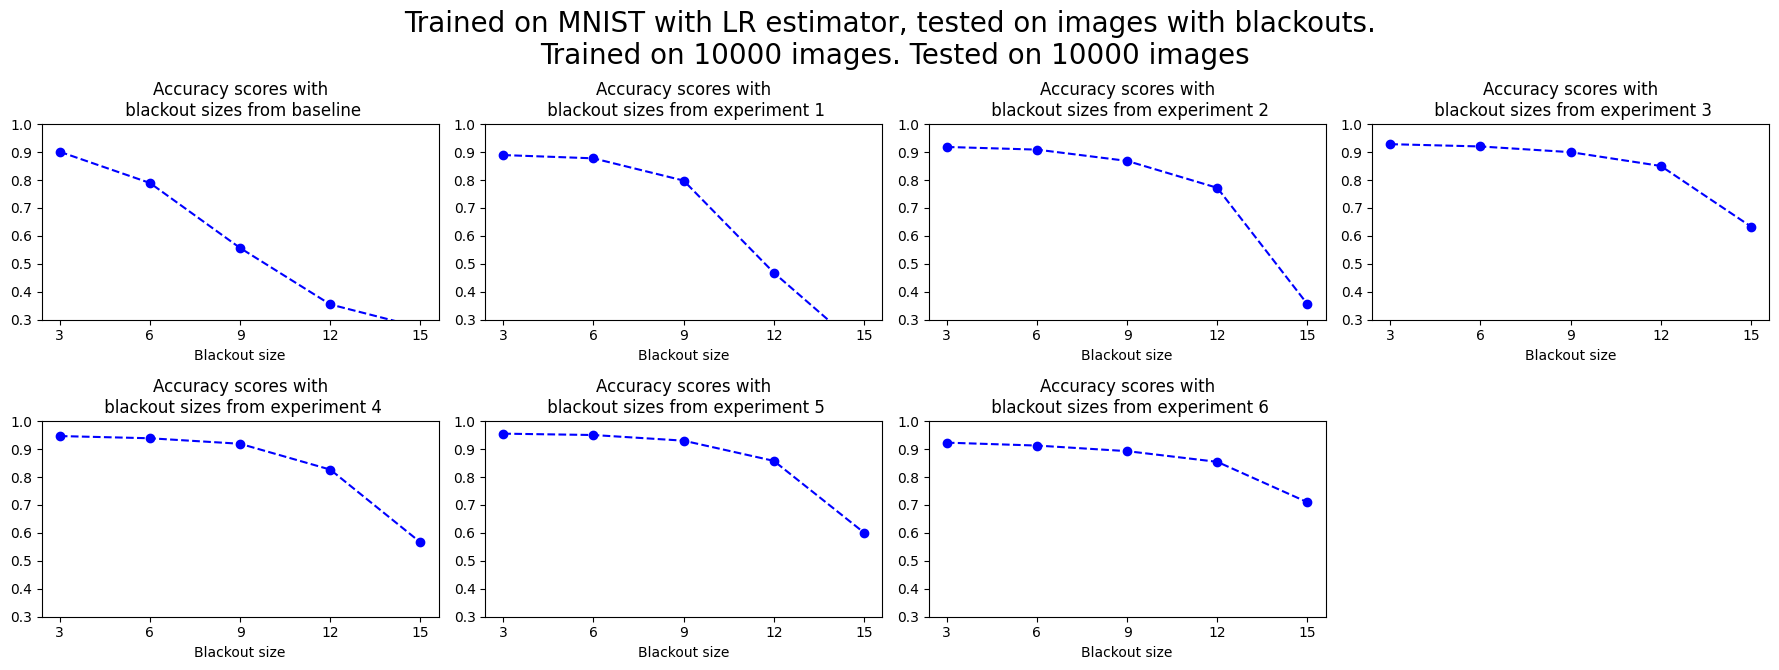

In [75]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7))
for i in range(7):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_lr[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from experiment {i}" if i > 0 else "Accuracy scores with\n blackout sizes from baseline")
    ax[k][j].set_ylim([.3, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with LR estimator, tested on images with blackouts. \nTrained on {int((1 - TEST_FRACTION) * DATA_SIZE)} images. Tested on {int(TEST_FRACTION * DATA_SIZE)} images",
             fontsize=20)
fig.delaxes(ax[1,3])

### SVM

In [54]:
scores_blackout_svm = []

#### Baseline - SVM

In [55]:
clfs_svm_blackout_bl = [SVC(kernel='rbf', C=svm_best_Cs["baseline"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_blackout_bl, transformed_flat_dataset_blackout))

#### Experiment 1 - SVM

In [56]:
clfs_svm_exp1_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp1"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp1_blackout, dataset_exp1_blackout))

#### Experiment 2 - SVM

In [57]:
clfs_svm_exp2_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp2"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp2_blackout, dataset_exp2_blackout))

#### Experiment 3 - SVM

In [58]:
clfs_svm_exp3_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp3"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp3_blackout, dataset_exp3_blackout))

#### Experiment 4 - SVM

In [59]:
clfs_svm_exp4_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp4"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp4_blackout, dataset_exp4_blackout))

#### Experiment 5 - SVM

In [60]:
clfs_svm_exp5_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp5"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp5_blackout, dataset_exp5_blackout))

#### Experiment 6 - SVM

In [61]:
clfs_svm_exp6_blackout = [SVC(kernel='rbf', C=svm_best_Cs["exp6"], gamma="auto") for _ in range(len(blackout_sizes))]
scores_blackout_svm.append(score_clfs_noisy(clfs_svm_exp6_blackout, dataset_exp6_blackout))

### Results - SVM

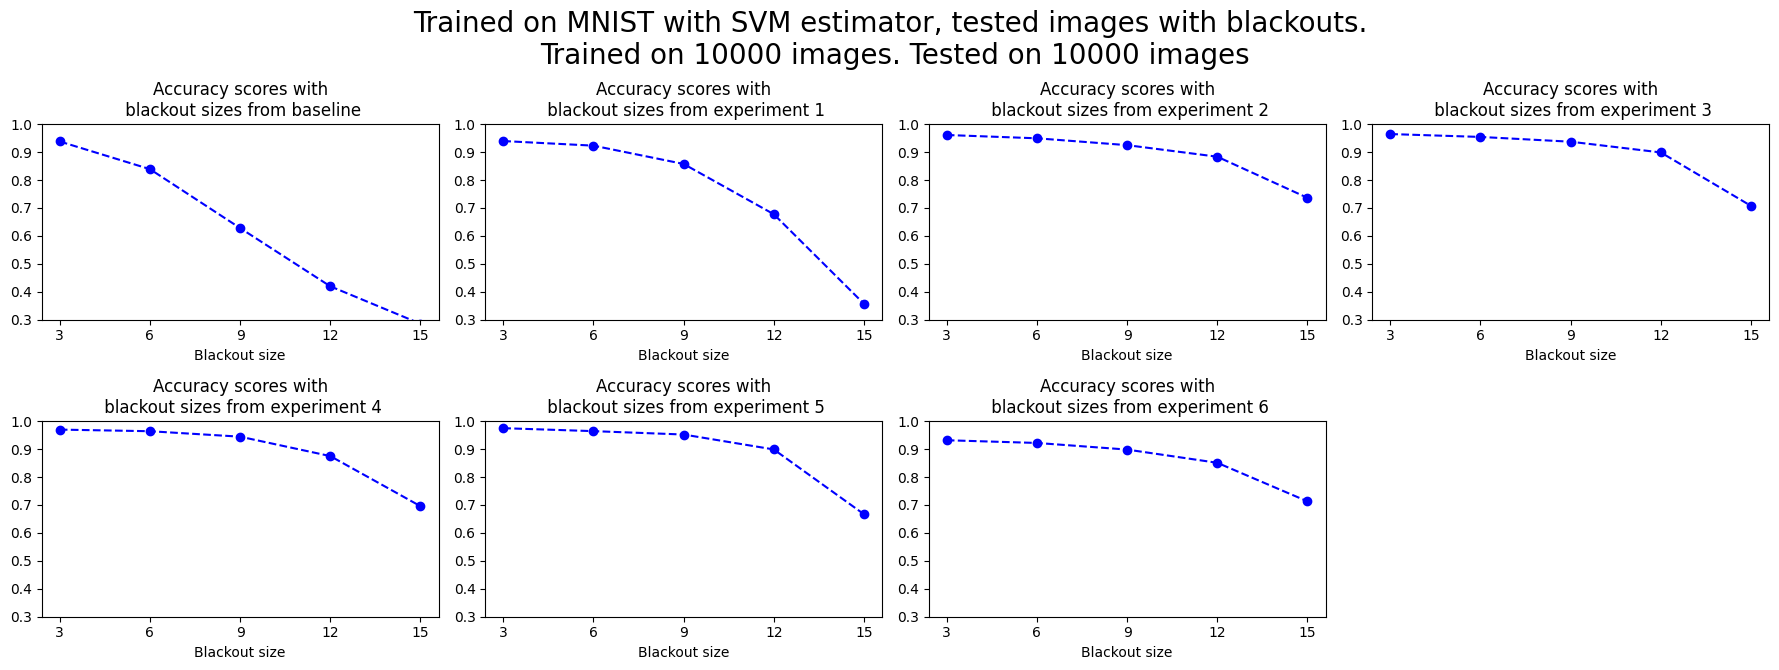

In [76]:
fig, ax = plt.subplots(2, 4, figsize=(18, 7))
for i in range(7):
    k, j = i // 4, i % 4
    ax[k][j].plot([str(t) for t in blackout_sizes], scores_blackout_svm[i], linestyle='--', marker='o', color='b', label='Accuracy score')
    ax[k][j].set_title(f"Accuracy scores with\n blackout sizes from experiment {i}" if i > 0 else "Accuracy scores with\n blackout sizes from baseline")
    ax[k][j].set_ylim([.3, 1.])
    ax[k][j].set_xlabel("Blackout size") 
fig.tight_layout(rect=(0., 0.03, 1., 0.9))
fig.suptitle(f"Trained on MNIST with SVM estimator, tested images with blackouts. \nTrained on {int((1 - TEST_FRACTION) * DATA_SIZE)} images. Tested on {int(TEST_FRACTION * DATA_SIZE)} images",
             fontsize=20)
fig.delaxes(ax[1,3])

### Testing with CNN - Baseline

In [120]:
cnn_blackout_scores_noise = []

In [128]:
def score_cnn_bl(clfs, dataset):
    scores = []
    batch_size = 128
    epochs = 15

    for i, clf in enumerate(clfs):
        X_te = dataset[i][1]
        X_te = np.array([black_out_section(img, blackout_sizes[i]) for img in X_te])
        clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        clf.fit(dataset[i][0], dataset[i][2], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        scores.append(clf.evaluate(X_te, dataset[i][3], verbose=0)[1])
    return scores

In [129]:
blackout_mnists_pixelshape = [np.expand_dims(data, -1) for data in blackout_mnists]
input_shape_blackout_bl = blackout_mnists_pixelshape[0][0].shape[-3:]
labels_binary_blackout = keras.utils.to_categorical(labels_train, classes)
transformed_baseline_dataset_blackout = [train_test_split(data_b, 
                                                          labels_binary_blackout,
                                                          test_size=0.25,
                                                          random_state=0) for data_b in noisy_mnists_pixelshape]

In [130]:
clfs_blackout_bl_cnn = [make_model_baseline(input_shape=input_shape, num_classes=classes) for _ in range(len(blackout_sizes))]
cnn_blackout_scores_noise.append(score_cnn_bl(clfs_blackout_bl_cnn, transformed_baseline_dataset_blackout))

Text(0.5, 1.0, 'CNN accuracy scores with blackout sizes from baseline')

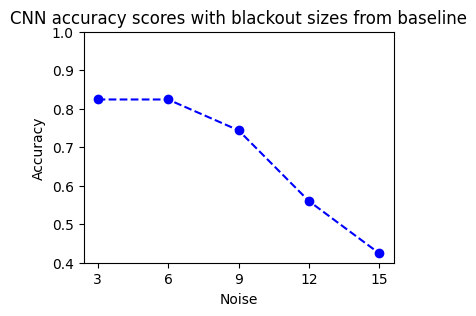

In [132]:
plt.plot([str(t) for t in blackout_sizes], cnn_blackout_scores_noise[0], linestyle='--', marker='o', color='b', label='Accuracy score')
plt.ylim([.4, 1.])
plt.ylabel("Accuracy")
plt.xlabel("Noise")
plt.title("CNN accuracy scores with blackout sizes from baseline")